# Import Libraries and Dataset

In [30]:
pip install --upgrade certifi

  Attempting uninstall: certifi
    Found existing installation: certifi 2023.7.22
    Uninstalling certifi-2023.7.22:
      Successfully uninstalled certifi-2023.7.22
Note: you may need to restart the kernel to use updated packages.


In [45]:
import os
# import cv2
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [10]:
cd "/Users/xunhongjiang/Desktop/2 - personal/Chest Disease Detection/"

/Users/xunhongjiang/Desktop/2 - personal/Chest Disease Detection


In [11]:
# Specify training data directory
XRay_Directory = 'Notebook/Chest_X_Ray/train'

In [12]:
# List the folders in the directory
os.listdir(XRay_Directory)

['0', '1', '3', '2']

In [13]:
# Use image generator to generate tensor images data and normalize them
# Use 20% of the data for cross-validation  
image_generator = ImageDataGenerator(rescale = 1./255, validation_split=0.2)

In [14]:
# Generate batches of 40 images
# Total number of images is 133*4 = 532 images
# Training is 428 (80%) and validation is 104 (20%)
# Perform shuffling and image resizing

train_generator = image_generator.flow_from_directory(batch_size = 40, directory = XRay_Directory, shuffle = True, target_size = (256,256), class_mode = 'categorical', subset = "training")

Found 428 images belonging to 4 classes.


In [15]:
validation_generator = image_generator.flow_from_directory(batch_size = 40,
                                                           directory = XRay_Directory, 
                                                           shuffle = True, 
                                                           target_size = (256,256), 
                                                           class_mode = 'categorical', 
                                                           subset = "validation")


Found 104 images belonging to 4 classes.


In [17]:
# Generate a batch of 40 images and labels
!pip install pillow
train_images, train_labels = next(train_generator)


In [18]:
train_labels

array([[1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.]],

In [19]:
# labels Translator 
label_names = {0 : 'Covid-19', 1 : 'Normal' , 2: 'Viral Pneumonia', 3 : 'Bacterial Pneumonia'}

# Data Visualization

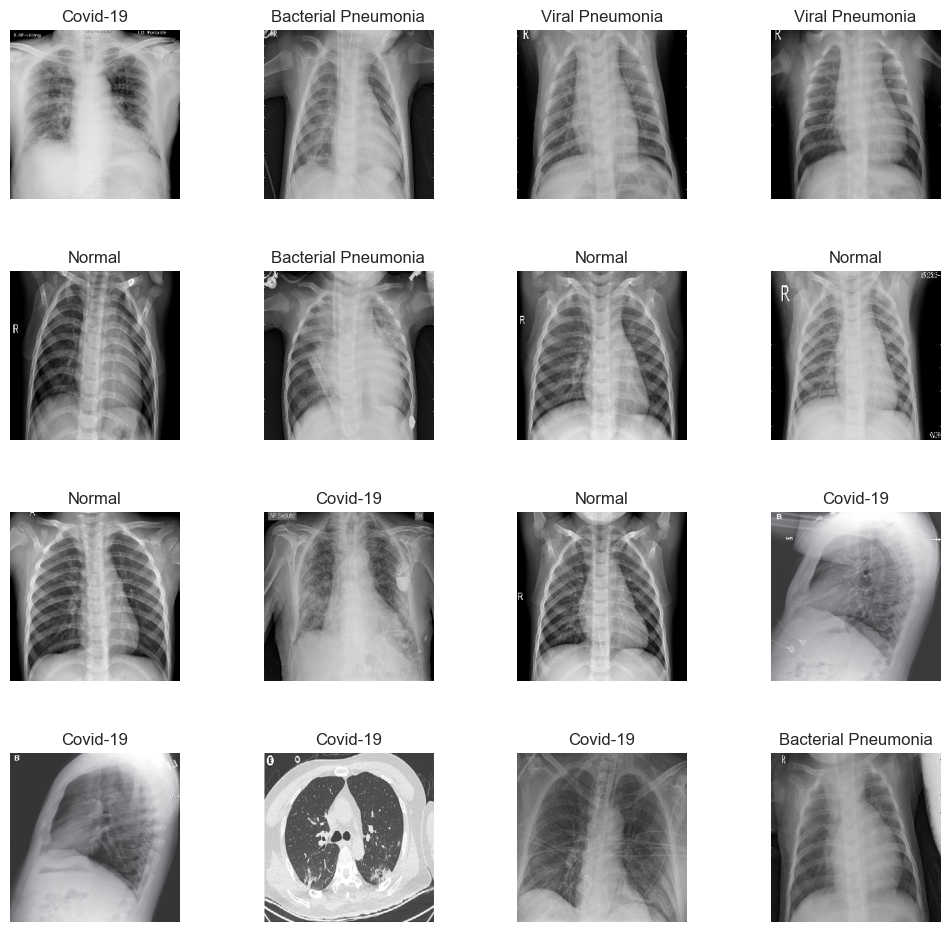

In [26]:
# Create a grid of 16 images along with their corresponding labels
L = 4
W = 4

fig, axes = plt.subplots(L, W, figsize=(12, 12))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(train_images[i])
    axes[i].set_title(label_names[np.argmax(train_labels[i])])
    axes[i].axis('off')  # Turn off the axis labels

plt.subplots_adjust(wspace=0.5)


# Import Model with Pretrained Weights

In [32]:
basemodel = ResNet50(weights='/Users/xunhongjiang/Desktop/2 - personal/Chest Disease Detection/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top = False, input_tensor = Input(shape = (256, 256, 3)))

In [33]:
basemodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_4[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [34]:
#freezing the model upto the last stage - 4 and re-training stage -5 

for layer in basemodel.layers[:-10]:
  layers.trainable = False

# Train Resnet Model with New Datasets

In [38]:
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)
headmodel = Flatten(name = 'flatten')(headmodel)
headmodel = Dense(256, activation = 'relu')(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(212856, activation = 'relu')(headmodel)
headmodel = Dropout(0.2)(headmodel)

headmodel = Dense(4, activation = 'softmax')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)

In [39]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_4[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [44]:
from tensorflow.keras.optimizers import legacy

model.compile(
    loss='categorical_crossentropy', 
    optimizer=legacy.RMSprop(learning_rate=1e-4, decay=1e-6),  # using legacy optimizer
    metrics=['accuracy']
)


In [46]:
# using early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="weights.hdf5", verbose=1, save_best_only=True)

In [47]:
train_generator = image_generator.flow_from_directory(batch_size = 4, directory= XRay_Directory, shuffle= True, target_size=(256,256), class_mode= 'categorical', subset="training")
val_generator = image_generator.flow_from_directory(batch_size = 4, directory= XRay_Directory, shuffle= True, target_size=(256,256), class_mode= 'categorical', subset="validation")

Found 428 images belonging to 4 classes.
Found 104 images belonging to 4 classes.


In [66]:
history = model.fit(train_generator, steps_per_epoch= train_generator.n // 4, epochs = 50, validation_data= val_generator, validation_steps= val_generator.n // 4, callbacks=[checkpointer, earlystopping])

Epoch 1/50
107/107 [==============================] - ETA: 0s - loss: 0.3800 - accuracy: 0.9533
Epoch 1: val_loss did not improve from 0.72063
107/107 [==============================] - 40s 186ms/step - loss: 0.3800 - accuracy: 0.9533 - val_loss: 8.9936 - val_accuracy: 0.7308
Epoch 2/50
107/107 [==============================] - ETA: 0s - loss: 0.3137 - accuracy: 0.9743
Epoch 2: val_loss did not improve from 0.72063
107/107 [==============================] - 18s 166ms/step - loss: 0.3137 - accuracy: 0.9743 - val_loss: 0.8587 - val_accuracy: 0.9038
Epoch 3/50
107/107 [==============================] - ETA: 0s - loss: 0.2910 - accuracy: 0.9673
Epoch 3: val_loss did not improve from 0.72063
107/107 [==============================] - 18s 166ms/step - loss: 0.2910 - accuracy: 0.9673 - val_loss: 0.9968 - val_accuracy: 0.9231
Epoch 4/50
107/107 [==============================] - ETA: 0s - loss: 0.4062 - accuracy: 0.9743
Epoch 4: val_loss did not improve from 0.72063
107/107 [=================

In [67]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [68]:
# load json and create model

from tensorflow.keras.models import model_from_json

json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("model.h5")
print("Loaded model from disk")


Loaded model from disk


# Evaluate Trained Deep Learning Model

In [69]:
#compile the model
from tensorflow.keras.optimizers import legacy

model.compile(
    optimizer=legacy.RMSprop(learning_rate=0.0001, decay=1e-6),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [70]:
test_directory = '/Users/xunhongjiang/Desktop/2 - personal/Chest Disease Detection/Notebook/Chest_X_Ray/Test'


In [71]:
test_gen = ImageDataGenerator(rescale = 1./255)

test_generator = test_gen.flow_from_directory(batch_size = 40, directory= test_directory, shuffle= True, target_size=(256,256), class_mode= 'categorical')

evaluate = model.evaluate_generator(test_generator, steps = test_generator.n // 4, verbose =1)

print('Accuracy Test : {}'.format(evaluate[1]))

Found 40 images belonging to 4 classes.


/var/folders/z5/f2p3m19x1jj43qhhdb47bymc0000gn/T/ipykernel_84791/3632543790.py:5: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  evaluate = model.evaluate_generator(test_generator, steps = test_generator.n // 4, verbose =1)


 1/10 [==>...........................] - ETA: 18s - loss: 9.1263 - accuracy: 0.7750WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 10 batches). You may need to use the repeat() function when building your dataset.


2024-08-10 12:10:11.748829: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 14575395822821143917


10/10 [==============================] - 2s 7ms/step - loss: 9.1263 - accuracy: 0.7750
Accuracy Test : 0.7749999761581421


In [72]:
!pip install opencv-python

In [73]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import cv2
prediction = []
original = []
image = []

for i in range(len(os.listdir(test_directory))):
  for item in os.listdir(os.path.join(test_directory,str(i))):
    img= cv2.imread(os.path.join(test_directory,str(i),item))
    img = cv2.resize(img,(256,256))
    image.append(img)
    img = img / 255
    img = img.reshape(-1,256,256,3)
    predict = model.predict(img)
    predict = np.argmax(predict)
    prediction.append(predict)
    original.append(i)

1/1 [==============================] - 0s 61ms/step


In [74]:
len(original)

40

In [75]:
score = accuracy_score(original,prediction)
print("Test Accuracy : {}".format(score))

Test Accuracy : 0.775


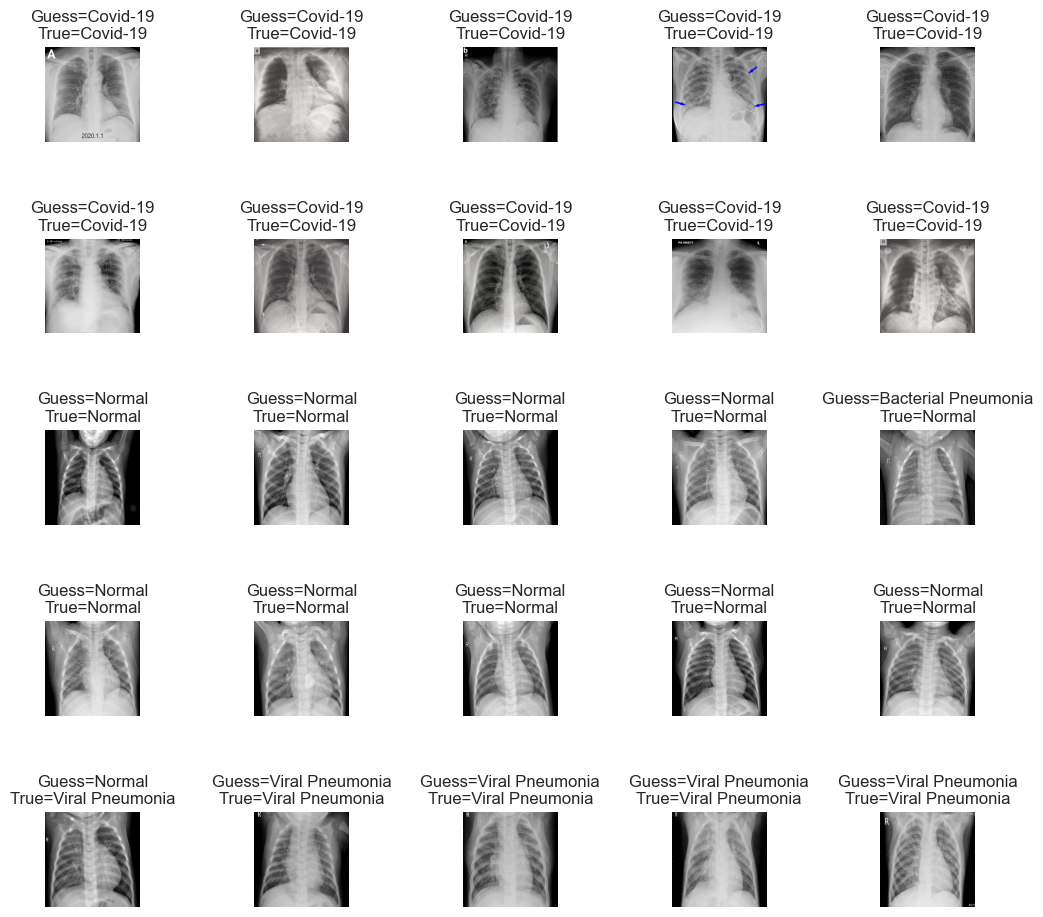

In [76]:
L = 5
W = 5

fig, axes = plt.subplots(L, W, figsize = (12, 12))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(image[i])
    axes[i].set_title('Guess={}\nTrue={}'.format(str(label_names[prediction[i]]), str(label_names[original[i]])))
    axes[i].axis('off')

plt.subplots_adjust(wspace = 1.2) 

In [77]:
print(classification_report(np.asarray(original), np.asarray(prediction)))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95        10
           1       0.69      0.90      0.78        10
           2       0.83      0.50      0.62        10
           3       0.70      0.70      0.70        10

    accuracy                           0.78        40
   macro avg       0.78      0.77      0.76        40
weighted avg       0.78      0.78      0.76        40



Text(0.5, 1.0, 'Confusion_matrix')

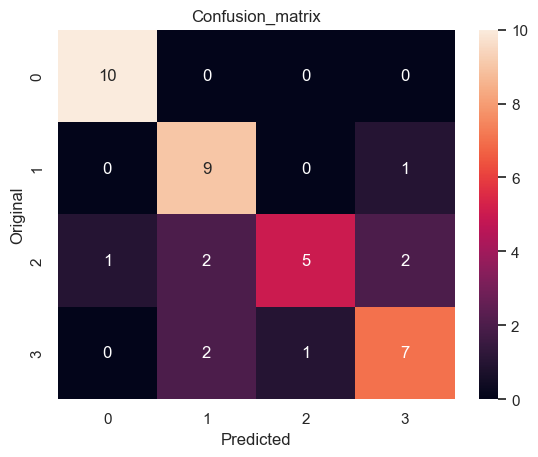

In [78]:
cm = confusion_matrix(np.asarray(original), np.asarray(prediction))
ax = plt.subplot()
sns.heatmap(cm, annot = True, ax = ax)

ax.set_xlabel('Predicted')
ax.set_ylabel('Original')
ax.set_title('Confusion_matrix')